# CS436 Project: 3D Scene Reconstruction
# Week 2: Two-View Reconstruction

**Group Members:**
* Choudhary Usman Alam, 26100383
* Muneeb ur Rehman, 26100346

**Objective:** Reconstruct a sparse 3D point cloud from two images using the Essential Matrix and Triangulation.

## Implementation Notes

**Key Implementation Details:**
1. **Feature Matching**: Using SIFT with Lowe's ratio test (threshold=0.85) for robust matching
2. **Essential Matrix**: Computed using RANSAC with `cv2.findEssentialMat()`
3. **Pose Recovery**: Using `cv2.recoverPose()` which automatically performs cheirality check
4. **Triangulation**: Using `cv2.triangulatePoints()` to reconstruct 3D points
5. **Critical Bug Fix**: OpenCV masks use values 0 and 255 (not 0 and 1), so we filter with `mask > 0`

## Imports and Setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

project_root = os.path.abspath(os.path.join('..'))
if os.path.join(project_root, 'src') not in sys.path:
    sys.path.append(os.path.join(project_root, 'src'))

from utils import load_images_from_folder, get_sift_matches, save_point_cloud_to_ply
from reconstruction import (
    get_intrinsic_matrix, 
    calculate_essential_matrix, 
    recover_camera_pose, 
    triangulate_points,
    get_inlier_points
)

print("Libraries and modules loaded successfully.")

Libraries and modules loaded successfully.


## Visualization Function

In [2]:
def visualize_results(points_3d):
    mean = np.mean(points_3d, axis=0)
    std = np.std(points_3d, axis=0)
    
    clean_mask = (np.abs(points_3d - mean) < 3 * std).all(axis=1)
    clean_points = points_3d[clean_mask]
    
    print(f"Visualizing {len(clean_points)} points (after removing extreme outliers).")
    
    X = clean_points[:, 0]
    Y = clean_points[:, 1]
    Z = clean_points[:, 2]

    fig = plt.figure(figsize=(18, 6))
    
    ax1 = fig.add_subplot(131, projection='3d')
    scatter = ax1.scatter(X, Y, Z, c=Z, cmap='viridis', s=2, alpha=0.6)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('3D Reconstruction Point Cloud')
    ax1.invert_yaxis()
    ax1.view_init(elev=30, azim=-45)
    plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(132)
    ax2.scatter(X, Y, c=Z, cmap='viridis', s=3, alpha=0.6)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('2D Scatter Plot (X-Y Projection)')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
    
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, c='blue', s=3, alpha=0.5)
    ax3.set_xlabel('X (Horizontal)')
    ax3.set_ylabel('Z (Depth)')
    ax3.set_title('Top-Down View (X-Z Projection)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Load Data

Successfully loaded 28 images from ../data
Images resized to max width: 1024px

Selected Image 2 and Image 5 for reconstruction.


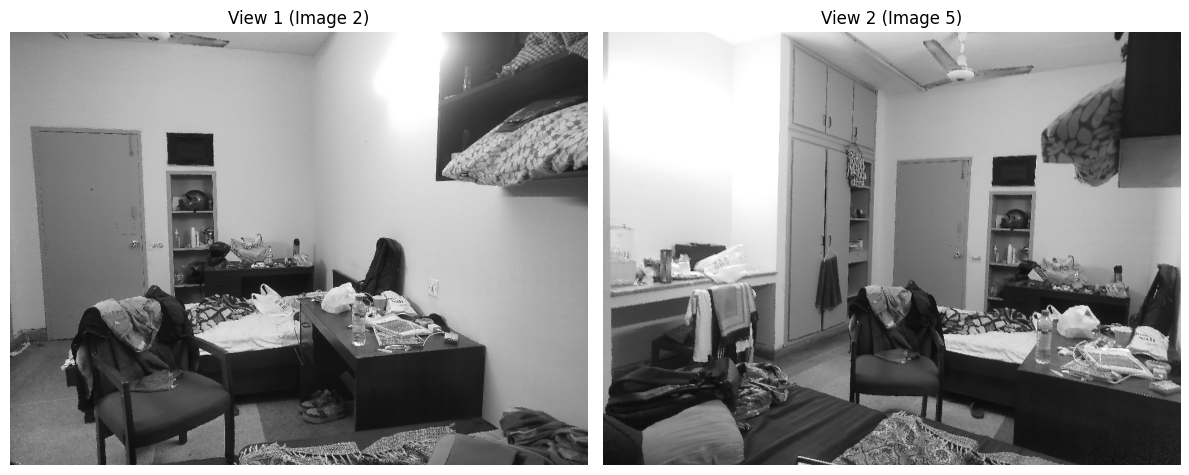

In [3]:
DATA_DIR = '../data'
images = load_images_from_folder(DATA_DIR)

IDX_1 = 2
IDX_2 = 5

if IDX_2 < len(images):
    img1 = images[IDX_1]
    img2 = images[IDX_2]

    print(f"\nSelected Image {IDX_1} and Image {IDX_2} for reconstruction.")
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(img1, cmap='gray'); plt.title(f"View 1 (Image {IDX_1})"); plt.axis('off')
    plt.subplot(1, 2, 2); plt.imshow(img2, cmap='gray'); plt.title(f"View 2 (Image {IDX_2})"); plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Error: Image Index out of range.")

## The Pipeline

1. Detecting and Matching Features...
   Found 220 raw matches.
2. Computing Intrinsic Matrix...
3. Computing Essential Matrix (RANSAC)...
   Found 220 raw matches.
2. Computing Intrinsic Matrix...
3. Computing Essential Matrix (RANSAC)...
   Inliers after RANSAC: 79
4. Recovering Camera Pose...
   Points passed Cheirality check: 79
5. Triangulating 3D Points...
Saved point cloud to reconstruction.ply

✅ SUCCESS: Reconstructed 79 3D points.
Visualizing 77 points (after removing extreme outliers).
   Inliers after RANSAC: 79
4. Recovering Camera Pose...
   Points passed Cheirality check: 79
5. Triangulating 3D Points...
Saved point cloud to reconstruction.ply

✅ SUCCESS: Reconstructed 79 3D points.
Visualizing 77 points (after removing extreme outliers).


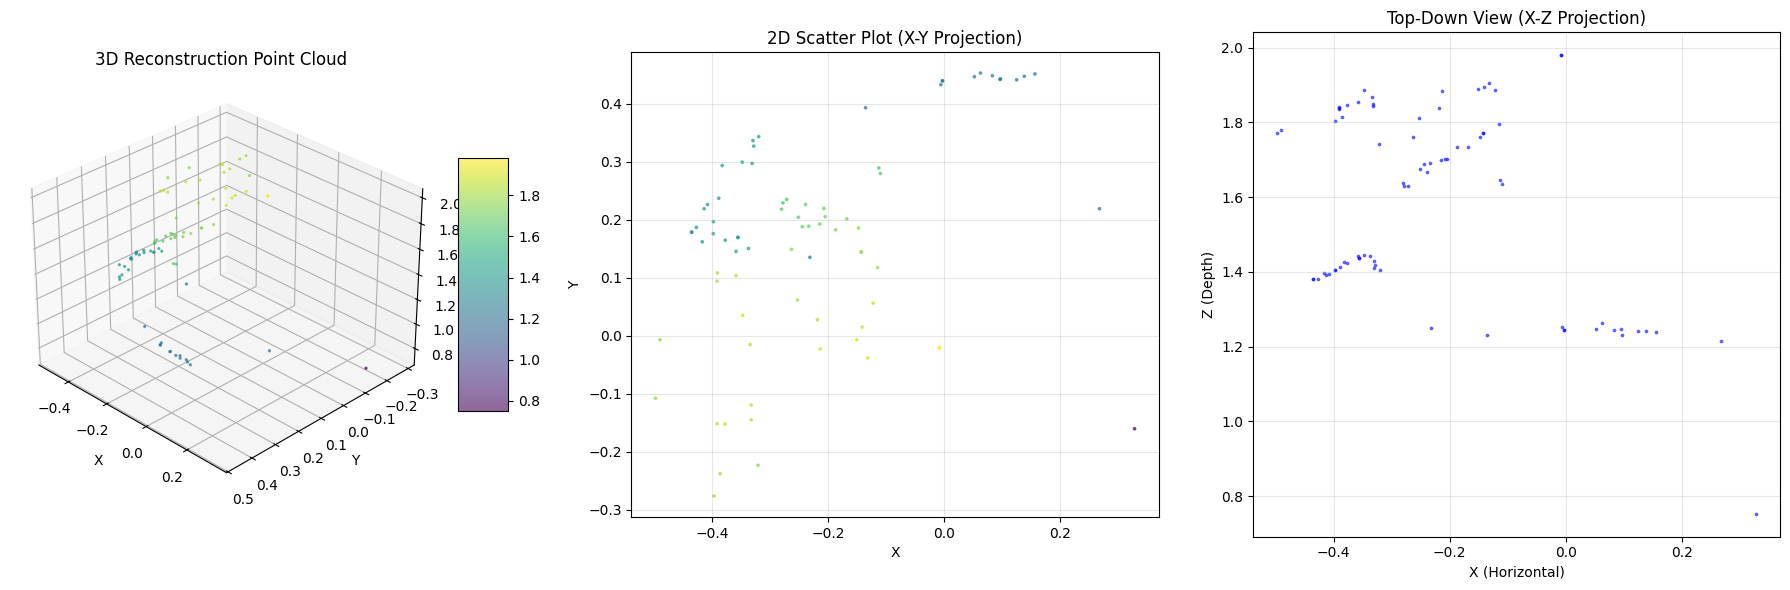

In [4]:
print("1. Detecting and Matching Features...")
kp1, kp2, good_matches = get_sift_matches(img1, img2)
print(f"   Found {len(good_matches)} raw matches.")

if len(good_matches) < 10:
    print("❌ ERROR: Too few matches.")
else:
    print("2. Computing Intrinsic Matrix...")
    K = get_intrinsic_matrix(img1.shape)

    print("3. Computing Essential Matrix (RANSAC)...")
    E, mask, pts1, pts2 = calculate_essential_matrix(kp1, kp2, good_matches, K)
    
    pts1_inliers, pts2_inliers = get_inlier_points(mask, pts1, pts2)
    print(f"   Inliers after RANSAC: {len(pts1_inliers)}")

    if len(pts1_inliers) < 10:
        print("❌ ERROR: RANSAC rejected too many points.")
    else:
        print("4. Recovering Camera Pose...")
        R, t, pose_mask = recover_camera_pose(E, pts1_inliers, pts2_inliers, K)
        
        pts1_final, pts2_final = get_inlier_points(pose_mask, pts1_inliers, pts2_inliers)
        print(f"   Points passed Cheirality check: {len(pts1_final)}")

        if len(pts1_final) > 0:
            print("5. Triangulating 3D Points...")
            points_3d = triangulate_points(R, t, K, pts1_final, pts2_final)
            
            save_point_cloud_to_ply(points_3d, "reconstruction.ply")
            
            print(f"\n✅ SUCCESS: Reconstructed {len(points_3d)} 3D points.")
            
            visualize_results(points_3d)
        else:
            print("❌ ERROR: No points passed the Cheirality check.")